In [1]:
using Flux
using CUDA
using Distributed

In [2]:
addprocs(16)

16-element Vector{Int64}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17

In [92]:
@everywhere include("sparseir_setting.jl")
#include("sparseir_setting.jl")

In [4]:
tanh5(x) = 5tanh(x)
tanh6(x) = 6tanh(x)
tanh8(x) = 8tanh(x)

tanh8 (generic function with 1 method)

In [5]:
function init_model(n_l::Int, n_gauss::Int, width::Int, depth::Int)
    model = Chain(Dense(n_l, width), (Dense(width, width, softplus) for i in 1:depth)..., Flux.Parallel(vcat, Dense(width, n_gauss, tanh), Dense(width, n_gauss, tanh6), Dense(width, n_gauss, tanh5)))
end

function init_model2(n_l::Int, n_gauss::Int, width::Int, depth::Int)
    model = Chain(Dense(n_l, width), BatchNorm(width), (Chain(Dense(width, width, softplus), BatchNorm(width)) for i in 1:depth)..., Flux.Parallel(vcat, Dense(width, n_gauss, tanh), Dense(width, n_gauss, tanh6), Dense(width, n_gauss, tanh5)))
end
function init_model4(n_l::Int, n_gauss::Int, width::Int, depth::Int)
    model = Chain(Dense(n_l, width), LayerNorm(width), (Chain(Dense(width, width, softplus), LayerNorm(width)) for i in 1:depth)..., Flux.Parallel(vcat, Dense(width, n_gauss, tanh), Dense(width, n_gauss, tanh6), Dense(width, n_gauss, tanh5)))
end

function init_model6(n_l::Int, n_gauss::Int, width::Int, depth::Int)
    model = Chain(Dense(n_l, width), LayerNorm(width), (Chain(Dense(width, width, tanh), LayerNorm(width)) for i in 1:depth)..., Flux.Parallel(vcat, Dense(width, n_gauss, tanh), Dense(width, n_gauss, tanh6), Dense(width, n_gauss, tanh5)))
end

function init_model5(n_l::Int, n_gauss::Int, width::Int, depth::Int)
    model = Chain(Dense(n_l, width), LayerNorm(width), (Chain(Dense(width, width), LayerNorm(width), softplus) for i in 1:depth)..., Flux.Parallel(vcat, Dense(width, n_gauss, tanh), Dense(width, n_gauss, tanh6), Dense(width, n_gauss, tanh5)))
end

function init_model3(n_l::Int, n_gauss::Int, width::Int, depth::Int)
    dd = div(depth, 2)
    model = Chain(Dense(n_l, width), (Chain(BatchNorm(width), Dense(width, width, softplus), Dense(width, width, softplus) ) for i in 1:dd)..., Flux.Parallel(vcat, Dense(width, n_gauss, tanh), Dense(width, n_gauss, tanh6), Dense(width, n_gauss, tanh5)))
end
#const proj5 = proj_m(5) |> gpu
function loss(model::Chain, K::Int, in, ans, λ::Float32)
    out = cpu(model(cu(in)))
    l = size(out)[2]
    phi = softmax(out[2K+1:3K,:])
    mu = out[1:K,:]
    logs = out[K+1:2K,:]
    sigma = exp.(logs)
    logts = ans[K+1:2K, :]
    true_sigma = exp.(logts)
    loss = sum(phi.*(((mu .- ans[1:K,:])./ sigma).^2 + (true_sigma./sigma).^2 - 2logts + 2logs)) + λ * sum(phi.*log.(phi ./ (ans[2K+1:3K, :] .+ 1f-10)))
    return loss/l - 1.0f0
end

function loss4(model::Chain, K::Int, in, ans, λ::Float32)
    out = cpu(model(cu(in)))
    l = size(out)[2]
    phi = softmax(out[2K+1:3K,:])
    mu = out[1:K,:]
    logs = out[K+1:2K,:]
    sigma = exp.(logs)
    logts = ans[K+1:2K, :]
    true_sigma = exp.(logts)
    loss = sum(phi.*(((mu .- ans[1:K,:])./ sigma).^2 + (true_sigma./sigma - sigma./true_sigma).^2)) + λ * sum(phi.*log.(phi ./ (ans[2K+1:3K, :] .+ 1f-10)))
    return loss/l
end

function loss3(model::Chain, K::Int, in, ans, λ::Float32)
    out = cpu(model(cu(in)))
    l = size(out)[2]
    phi = softmax(out[2K+1:3K,:])
    mu = out[1:K,:]
    logs = out[K+1:2K,:]
    sigma = exp.(logs)
    logts = ans[K+1:2K, :]
    true_sigma = exp.(logts)
    loss = sum(phi.*((mu .- ans[1:K,:]).^2 ./ sigma + (true_sigma./sigma) + (logts - logs).^2 )) + λ * sum(phi.*log.(phi ./ (ans[2K+1:3K, :] .+ 1f-8)))
    return loss/l
end

function loss1(model::Chain, K::Int, in, ans, λ::Float32)
    out = cpu(model(cu(in)))
    l = size(out)[2]
    phi = softmax(out[2K+1:3K,:])
    true_phi = ans[2K+1:3K, :]

    mu = out[1:K,:]
    logs = out[K+1:2K,:]
    sigma = exp.(logs)
    logts = ans[K+1:2K, :]
    true_sigma = exp.(logts)
    loss = sum(true_phi.*((mu .- ans[1:K,:])./ true_sigma).^2 + (sigma./true_sigma).^2 - 2logs + 2logts) + λ * sum(true_phi.* (log.(true_phi) .- log.(phi)))
    return loss/l
end

function loss2(model::Chain, K::Int, in, ans, λ::Float32)
    out = cpu(model(cu(in)))
    l = size(out)[2]
    phi = softmax(out[2K+1:3K,:])
    true_phi = ans[2K+1:3K, :]
    mu = out[1:K,:]
    sigma = out[K+1:2K,:]
    t_sigma = ans[K+1:2K, :]
    loss = sum(true_phi .* ((mu .- ans[1:K,:]).^2 ./ exp.(t_sigma) + (sigma .- t_sigma).^2)) + λ * sum(phi.*log.(phi ./ (true_phi .+ 1f-10)))
    return loss/l
end

loss2 (generic function with 1 method)

In [6]:
@everywhere using SharedArrays 

In [33]:
function dataset(n::Int, w_size::Int, n_gauss::Int, ir::IR_params)
    l = length(ir.basis.s)
    inputs = SharedArray(zeros(Float32, l, n))
    outputs = SharedArray(zeros(Float32, 3n_gauss, n))
    @sync @distributed for i in 1:n
        inputs[:,i], outputs[:,i] = create_data7(w_size, n_gauss, ir)
    end
    return Matrix(inputs), Matrix(outputs)
end

dataset (generic function with 1 method)

In [8]:
ir_test = set_IR(100.0, 1.0, 1e-10)

IR_params(100.0, 1.0, FiniteTempBasis{Fermionic, LogisticKernel}(LogisticKernel(100.0), SparseIR.SVEResult{LogisticKernel}(SparseIR.PiecewiseLegendrePoly[SparseIR.PiecewiseLegendrePoly(16, -1.0, 1.0, [-1.0, -0.9971969191007053, -0.9939631887430201, -0.9902327485573953, -0.9859294594055299, -0.9809655949653976, -0.9752401232983684, -0.9686367577352446, -0.9610217593708021, -0.9522414800459728  …  0.9522414800459728, 0.9610217593708021, 0.9686367577352446, 0.9752401232983684, 0.9809655949653976, 0.9859294594055299, 0.9902327485573953, 0.9939631887430201, 0.9971969191007053, 1.0], [0.0028030808992947076, 0.0032337303576851495, 0.0037304401856248504, 0.004303289151865397, 0.004963864440132304, 0.005725471667029192, 0.0066033655631237975, 0.00761499836444246, 0.008780279324829388, 0.010121832962441735  …  0.010121832962441735, 0.008780279324829388, 0.00761499836444246, 0.0066033655631237975, 0.005725471667029192, 0.004963864440132304, 0.004303289151865397, 0.0037304401856248504, 0.003233730

In [9]:
using ProgressMeter

In [10]:
K=5

5

In [11]:
using JLD2

In [34]:
dt_test = Flux.DataLoader(dataset(16384, 10001, K, ir_test), batchsize=2048, shuffle=true)

8-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=2048)
  with first element:
  (30×2048 Matrix{Float32}, 15×2048 Matrix{Float32},)

In [12]:
dt_test = load("data_16384_e10_data6.jld2")["dt_test"]

8-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=2048)
  with first element:
  (30×2048 Matrix{Float32}, 15×2048 Matrix{Float32},)

In [14]:
#dt_test = dt_test0["dt_test"]

8-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=2048)
  with first element:
  (30×2048 Matrix{Float32}, 15×2048 Matrix{Float32},)

In [32]:
dt_test2 = Flux.DataLoader(dataset(65536, 10001, K, ir_test), batchsize=8192, shuffle=true)

8-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=8192)
  with first element:
  (30×8192 Matrix{Float32}, 15×8192 Matrix{Float32},)

In [54]:
@save "data_65536_e10_8192_data6.jld2" dt_test2

In [35]:
@save "data_16384_e10_data7.jld2" dt_test

In [13]:
using Plots

create data!


Progress: 100%|█████████████████████████████████████████| Time: 0:42:18m


it: 1, loss: 0.22268629
it: 1, loss: 0.22175953


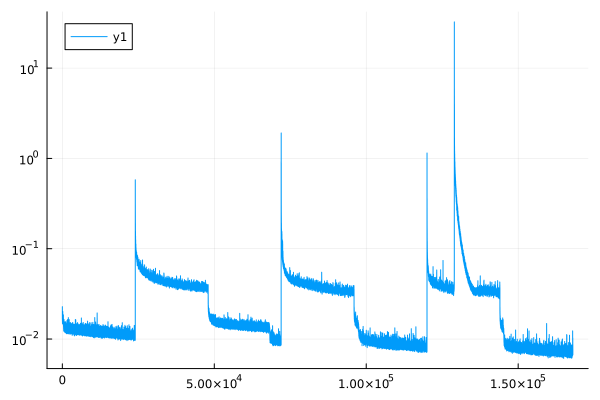

In [69]:

l = length(ir_test.basis.s)
term = 3000

#model_test = init_model6(l, K, 256, 16) |> gpu
test_data = []
lss = []
for it in 1:1
    if(it < 5)
        opt = Flux.Optimiser(WeightDecay(1f-5), Adam(2f-4))
        #opt_state = Flux.setup(opt, model_test) 
    elseif(it < 13)
        opt = Flux.Optimiser(WeightDecay(1f-6), Adam(1f-4))
        #opt_state = Flux.setup(opt, model_test)
    else
        opt = Flux.Optimiser(WeightDecay(1f-5), Adam(2f-5))
        #opt_state = Flux.setup(opt, model_test) 
    end
    dt = dt_test
    #@time dt = Flux.DataLoader(dataset(4096, 4001, K, ir_test), batchsize=512, shuffle=true)
    #@time dt = Flux.DataLoader(dataset(64, 4001, K, ir_test), batchsize=32, shuffle=true)
    println("create data!")
    #=
    @showprogress for epoch in 1:2000
        #for (input, target) in dt
        for (input, target) in dt
            val, grads = Flux.withgradient(Flux.params(model_test)) do
            #grads = Flux.gradient(Flux.params(model_test)) do
                loss2(model_test, K, input, target, 2.0f0)
            end
            Flux.Optimise.update!(opt, Flux.params(model_test), grads)
            #Flux.update!(opt_state, model_test, grads[1])
            push!(lss, val)
        end
        if(epoch == 250)
            opt = Flux.Optimiser(WeightDecay(1f-6), Adam(2f-4))
        elseif(epoch == 500)
            opt = Flux.Optimiser(WeightDecay(1f-6), Adam(5f-5))
        elseif(epoch == 1000)
            opt = Flux.Optimiser(WeightDecay(1f-6), Adam(1f-5))
            #Flux.adjust!(opt_state, 1f-3)
            #println("epoch: $(epoch), loss: $(lss[end])")
        end
        #=Flux.train!(model_test, dt, opt_state) do m,x,y
            loss(m, K, x, y, 2.0f0)
        end=#
    end=#
    @showprogress for epoch in 1:7term
        if(epoch % 2term < term + 1)
            if(epoch%(2term) == 1)
                opt = Flux.Optimiser(WeightDecay(1f-7), Adam(4f-6))
                #opt = Adam(4f-6)
            end
            for (input, target) in dt
                val, grads = Flux.withgradient(Flux.params(model_test)) do
                #grads = Flux.gradient(Flux.params(model_test)) do
                    loss2(model_test, K, input, target, 5.0f0)
                end
                Flux.Optimise.update!(opt, Flux.params(model_test), grads)
                #Flux.update!(opt_state, model_test, grads[1])
                push!(lss, val)
            end
        else
            if(epoch % 2term == term + 1)
                opt = Flux.Optimiser(WeightDecay(1f-7), Adam(4f-6))
                #opt = Adam(4f-6)
            end
            for (input, target) in dt
                val, grads = Flux.withgradient(Flux.params(model_test)) do
                #grads = Flux.gradient(Flux.params(model_test)) do
                    loss4(model_test, K, input, target, 5.0f0)
                    #loss(model_test, K, input, target, 5.0f0)
                end
                Flux.Optimise.update!(opt, Flux.params(model_test), grads)
                #Flux.update!(opt_state, model_test, grads[1])
                push!(lss, val)
            end
        end
        #=Flux.train!(model_test, dt, opt_state) do m,x,y
            loss(m, K, x, y, 2.0f0)
        end=#
    end
    test = first(dt)
    println("it: $(it), loss: $(loss4(model_test, K, test[1], test[2], 2.0f0))")
    println("it: $(it), loss: $(loss4(model_test, K, test[1], test[2], 0.0f0))")
    push!(test_data, test)
end
plot(lss,yaxis=:log10, yticks=[1e1, 1e0,1e-1,1e-2, 1e-3, 1e-4])

In [36]:
GC.gc()
opt = nothing

In [38]:
using Plots

In [16]:
function gmm1(K::Int, w::Float32, μ::Vector{Float32}, Σ::Vector{Float32}, ϕ::Vector{Float32})
    #μ, Σ, ϕ = p.μ, p.Σ, p.ϕ
    y = sum([ϕ[i]*pdf(Normal(μ[i], Σ[i]), w) for i in 1:K])
    return y
end
#=
function data2dist(out::Vector{Float32}, K::Int, w_size::Int)
    ws = [range(-1.0f0,1.0f0, length=w_size)...]
    l = length(out)
    phi = out[2K+1:3K]
    mu = out[1:K]
    sigma = out[K+1:2K]
    rho = [gmm1(K, w, mu, sigma, phi) for w in ws]
    return rho
end=#

function data2dist(out::Vector{Float32}, K::Int, w_size::Int)
    ws = [range(-1.0f0,1.0f0, length=w_size)...]
    l = length(out)
    phi = out[2K+1:3K]
    mu = out[1:K]
    sigma = exp.(out[K+1:2K])
    rho = [gmm1(K, w, mu, sigma, phi) for w in ws]
    return rho
end

function out2dist(out::Vector{Float32}, K::Int, w_size::Int)
    ws = [range(-1.0f0,1.0f0, length=w_size)...]
    l = length(out)
    phi = softmax(out[2K+1:3K])
    mu = out[1:K]
    sigma = exp.(out[K+1:2K])
    rho = [gmm1(K, w, mu, sigma, phi) for w in ws]
    return rho
end

out2dist (generic function with 1 method)

id = rand(1:1024) = 457
Float32[-0.34277102; -0.59828645; 0.11836863; -0.11010514; -0.12116239;;]
Float32[0.36155388; 0.0037652766; 0.016418096; 0.06741961; 0.14150749;;]
Float32[0.0011938339; 0.00245939; 0.035860486; 0.3099836; 0.6505027;;]
Float32[0.5792283, -0.5969061, 0.12501678, -0.111005984, -0.119741015]
Float32[0.38213, 0.0033029232, 0.015991617, 0.067970216, 0.14115444]
Float32[0.0005552338, 0.0026418187, 0.03684755, 0.31015757, 0.64979786]
Float32[-0.92199934, -0.0013803244, -0.0066481456, 0.00090084225, -0.0014213771, -0.055349827, 0.1310134, 0.026319504, -0.00813365, 0.0024980307, 2.4888916, 0.9303235, -1.6715969, -3.5277653, -3.926827]


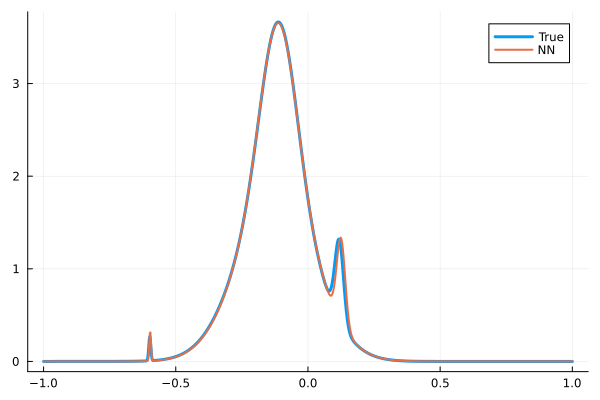

In [85]:
test_gl, gmm_test = test_data[1]
#create_data5(4001, K, ir_test)
@show id = rand(1:1024)

println(gmm_test[1:K,id:id])
println(exp.(gmm_test[K+1:2K,id:id]))
println(gmm_test[2K+1:3K,id:id])
test_out = cpu(model_test(cu(test_gl[:,id:id])))
println(test_out[1:K,1])
println(exp.(test_out[K+1:2K,1]))
println(softmax(test_out[2K+1:3K,1]))
rho_true = data2dist(gmm_test[:,id], K, 1001)
println(gmm_test[:,id]-test_out[:,1])
rho_NN = out2dist(test_out[:,1], K, 1001)
ws_test = [range(-1.0f0,1.0f0, length=1001)...]

plot(ws_test, rho_true, linewidth=3, label="True")
plot!(ws_test, rho_NN, linewidth=2, label="NN")

Float32[-0.052649785, 0.32704216, 0.24299596, 0.4989385, 0.060891304]
Float32[0.007894602, 0.049148876, 0.0065948656, 0.0031054588, 0.20622058]
Float32[0.00020809667, 0.0009845849, 0.0035167397, 0.042402662, 0.9528879]
Float32[-0.04021094, -0.8383333, -0.01873918, 0.14163338, 0.1142153]
Float32[0.0064902226, 0.02016019, 0.093331374, 0.017254967, 0.2150219]
Float32[0.0019002552, 0.004268614, 0.0135254515, 0.019271437, 0.9610342]


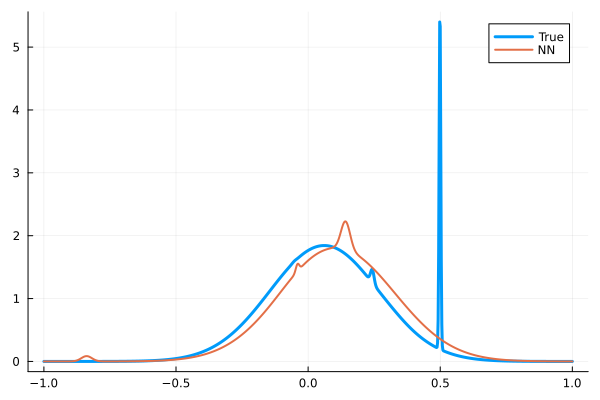

In [88]:
test_gl0, gmm_test0 = create_data7(10001, K, ir_test)
#id = 2
println(gmm_test0[1:K])
println(exp.(gmm_test0[K+1:2K]))
println(gmm_test0[2K+1:3K])
test_out0 = cpu(model_test(cu(test_gl0)))
println(test_out0[1:K])
println(exp.(test_out0[K+1:2K]))
println(softmax(test_out0[2K+1:3K]))
rho_true0 = data2dist(gmm_test0, K, 1001)
rho_NN0 = out2dist(test_out0, K, 1001)
ws_test = [range(-1.0f0,1.0f0, length=1001)...]
plot(ws_test, rho_true0, linewidth=3, label="True")
plot!(ws_test, rho_NN0, linewidth=2, label="NN")

itr: 277 logpx: 0.88662446 converged!
D_kl: -0.011716694


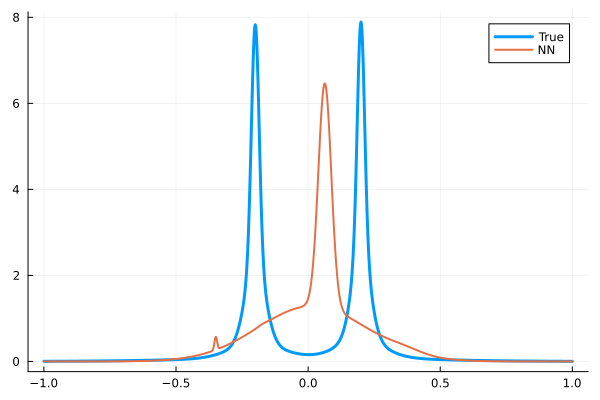

In [97]:
ws0 = [range(-1.0,1.0, length=10001)...]
wsf = Float32.(ws0)
#gg(x, η) = (2η/((x-0.1)^2+η^2))/(2pi)
gg(x, η) = (2η/((x-0.2)^2+η^2) + 2η/((x+0.2)^2+η^2))/(4pi)
true_ρ = Float32[gg(w, 0.02f0) for w in ws0]
gp =  EM(0.01f0, 10, wsf, true_ρ)
gmm_rho0 = gmm_rho(ws0, gp)
gl0 = Float32.(loginv.(rho2gl(ws0, gmm_rho0, ir_test)))
test_out0 = cpu(model_test(cu(gl0)))

ws_test = [range(-1.0,1.0, length=1001)...]
rho_true0 = gmm_rho(ws_test, gp)
rho_NN0 = out2dist(test_out0, K, 1001)

plot(ws_test, rho_true0, linewidth=3, label="True")
plot!(ws_test, rho_NN0, linewidth=2, label="NN")

In [75]:
c_model = cpu(model_test)

Chain(
  Dense(30 => 256),                     # 7_936 parameters
  LayerNorm(256),                       # 512 parameters
  Chain(
    Dense(256 => 256, tanh),            # 65_792 parameters
    LayerNorm(256),                     # 512 parameters
  ),
  Chain(
    Dense(256 => 256, tanh),            # 65_792 parameters
    LayerNorm(256),                     # 512 parameters
  ),
  Chain(
    Dense(256 => 256, tanh),            # 65_792 parameters
    LayerNorm(256),                     # 512 parameters
  ),
  Chain(
    Dense(256 => 256, tanh),            # 65_792 parameters
    LayerNorm(256),                     # 512 parameters
  ),
  Chain(
    Dense(256 => 256, tanh),            # 65_792 parameters
    LayerNorm(256),                     # 512 parameters
  ),
  Chain(
    Dense(256 => 256, tanh),            # 65_792 parameters
    LayerNorm(256),                     # 512 parameters
  ),
  Chain(
    Dense(256 => 256, tanh),            # 65_792 parameters
    LayerNorm(256),   

In [77]:
jldsave("model_e10_1.jld2", model_state = Flux.state(c_model))